In [1]:
import os
os.environ['NETKET_EXPERIMENTAL_SHARDING'] = '1'
os.environ['NETKET_EXPERIMENTAL_FFT_AUTOCORRELATION'] = '1'
os.environ["CUDA_VISIBLE_DEVICES"] = "5"

In [2]:
import netket as nk
import json
import sys
# sys.path.append('/Users/samizweidler/Documents/ETH/4_6_Master/6.Jahr/Master_Thesis/AFM_VMC')
sys.path.append('/scratch/samiz/GPU_ViT_Calcs/Vscore_ThermodynamicLimit_Analysis/AFM_VMC')

import jax.numpy as jnp
import matplotlib.pyplot as plt

import flax.linen as nn
from typing import Any
from netket.jax import logsumexp_cplx

from Afm_Model_functions import *
from vmc_2spins_sampler import *
from Spin_Observables import *
import pickle
import ViT_2d_Vers5 as vit
from data_extracter import *
from jax import vmap

In [3]:
L = 12
Tri12 = nk.graph.Triangular(extent = [L,L], pbc = True)

pHa = {
    'L': L,
    'J1' : 1.0,
    'J2' : 0.4375,
    'Dxy': 0.75,
    'd' : 0.1,
    'dprime' : 0.5,
    'sublattice_12':[0,1,2,3,4,5,6,7,8,9,10,11,
                   24,25,26,27,28,29,30,31,32,33,34,35,
                   48,49,50,51,52,53,54,55,56,57,58,59,
                   72,73,74,75,76,77,78,79,80,81,82,83,
                   96,97,98,99,100,101,102,103,104,105,106,107,
                   120,121,122,123,124,125,126,127,128,129,130,131]
}

Ha12, hi12 = H_afmJ123(L=pHa['L'], J1=pHa['J1'], J2=pHa['J2'], J3=pHa['J2'], Dxy=pHa['Dxy'], d=pHa['d'], dprime=pHa['dprime'], return_space=True,
                        parity=0., sublattice = pHa['sublattice_12'], make_rotation=True, exchange_XY=True)

pHa['sublattice_14'] = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,
                   28,29,30,31,32,33,34,35,36,37,38,39,40,41,
                   56,57,58,59,60,61,62,63,64,65,66,67,68,69,
                   84,85,86,87,88,89,90,91,92,93,94,95,96,97,
                   112,113,114,115,116,117,118,119,120,121,122,123,124,125,
                   140,141,142,143,144,145,146,147,148,149,150,151,152,153,
                   168,169,170,171,172,173,174,175,176,177,178,179,180,181]


Ha14, hi14 = H_afmJ123(L=14, J1=pHa['J1'], J2=pHa['J2'], J3=pHa['J2'], Dxy=pHa['Dxy'], d=pHa['d'], dprime=pHa['dprime'], return_space=True,
                        parity=0., sublattice = pHa['sublattice_14'], make_rotation=True, exchange_XY=True)
Tri14 = nk.graph.Triangular(extent = [14,14], pbc = True)

XX12 = Exchange_OP(hi12, Tri12).to_jax_operator()
sa_Ha12 = nk.sampler.MetropolisHamiltonian(hilbert=hi12, hamiltonian=XX12, n_chains=32, sweep_size = 3* hi12.size)
sa_ex12 = nk.sampler.MetropolisExchange(hilbert=hi12, graph=Tri12, n_chains=32, sweep_size=3*hi12.size)
rules5050_12 = nk.sampler.rules.MultipleRules(rules = [sa_Ha12.rule, sa_ex12.rule], probabilities = [0.5, 0.5])
sa_HaEx_L12 = nk.sampler.MetropolisSampler(hi12, rules5050_12, n_chains=64, sweep_size=3*hi12.size)
sa_HaEx_L12 = nk.sampler.MetropolisSampler(hi12, rules5050_12, n_chains=64, sweep_size=3*hi12.size)

XX14 = Exchange_OP(hi14, Tri14).to_jax_operator()
sa_Ha14 = nk.sampler.MetropolisHamiltonian(hilbert=hi14, hamiltonian=XX14, n_chains=32, sweep_size = 3* hi14.size)
sa_ex14 = nk.sampler.MetropolisExchange(hilbert=hi14, graph=Tri14, n_chains=32, sweep_size=3*hi14.size)
rules5050_14 = nk.sampler.rules.MultipleRules(rules = [sa_Ha14.rule, sa_ex14.rule], probabilities = [0.5, 0.5])
sa_HaEx_L14 = nk.sampler.MetropolisSampler(hi14, rules5050_14, n_chains=64, sweep_size=3*hi14.size)
sa_HaEx_L14 = nk.sampler.MetropolisSampler(hi14, rules5050_14, n_chains=64, sweep_size=3*hi14.size)


In [4]:
def Sz_tot(graph, hilbert):
    """
    input:
    graph: (netket.graph) the graph of the system
    hilbert: (netket.hilbert) the hilbert space of the system

    return:
    the total Sz operator
    """
    Sz = 0.0
    Ntot = graph.n_nodes
    for i in range(Ntot):
        Sz += sigmaz(hilbert, i)
    return Sz/Ntot

Mtot12 = Sz_tot(nk.graph.Triangular(extent=[L,L], pbc=True), hi12)
Mtot14 = Sz_tot(nk.graph.Triangular(extent=[14,14], pbc=True), hi14)

In [5]:
pVit = {
    'd': 32,
    'h': 8,
    'nl': 1,
    'Dtype': jnp.float64,
    'hidden_density': 1,
    'L': L,
    'Cx': 4,
    'Cy': 4,
    'patch_arr': HashableArray(jnp.array([[0,1,2,3,12,13,14,15,24,25,26,27,36,37,38,39],
                                          [4,5,6,7,16,17,18,19,28,29,30,31,40,41,42,43],
                                          [8,9,10,11,20,21,22,23,32,33,34,35,44,45,46,47],
                                          [48,49,50,51,60,61,62,63,72,73,74,75,84,85,86,87],
                                          [52,53,54,55,64,65,66,67,76,77,78,79,88,89,90,91],
                                          [56,57,58,59,68,69,70,71,80,81,82,83,92,93,94,95],
                                          [96,97,98,99,108,109,110,111,120,121,122,123,132,133,134,135],
                                          [100,101,102,103,112,113,114,115,124,125,126,127,136,137,138,139],
                                          [104,105,106,107,116,117,118,119,128,129,130,131,140,141,142,143],
                                         ]))
    }

patch_transl_12 = HashableArray(vit.get_translation(12, 12, 12**2, pVit['Cx'], pVit['Cy']))

m_Vit_12 = vit.Vit_2d_full_symm(patch_arr=HashableArray(pVit['patch_arr']), embed_dim=pVit['d'], num_heads=pVit['h'], nl=pVit['nl'],
                                Dtype=pVit['Dtype'], L=pVit['L'], Cx=pVit['Cx'], Cy=pVit['Cy'], hidden_density=pVit['hidden_density'],
                                recover_full_transl_symm=True, translations = patch_transl_12, recover_spin_flip_symm=True)


pVit['patch_arr'] = HashableArray(jnp.array([[0,1,14,15,28,29,42,43,56,57,70,71,84,85], [98,99,112,113,126,127,140,141,154,155,168,169,182,183],
                                          [2,3,16,17,30,31,44,45,58,59,72,73,86,87], [100,101,114,115,128,129,142,143,156,157,170,171,184,185],
                                          [4,5,18,19,32,33,46,47,60,61,74,75,88,89], [102,103,116,117,130,131,144,145,158,159,172,173,186,187],
                                          [6,7,20,21,34,35,48,49,62,63,76,77,90,91], [104,105,118,119,132,133,146,147,160,161,174,175,188,189],
                                          [8,9,22,23,36,37,50,51,64,65,78,79,92,93], [106,107,120,121,134,135,148,149,162,163,176,177,190,191],
                                          [10,11,24,25,38,39,52,53,66,67,80,81,94,95], [108,109,122,123,136,137,150,151,164,165,178,179,192,193],
                                          [12,13,26,27,40,41,54,55,68,69,82,83,96,97], [110,111,124,125,138,139,152,153,166,167,180,181,194,195],
                                         ]))

patch_transl_14 = HashableArray(vit.get_translation(14, 14, 14**2, 7, 2))
m_Vit_14 = vit.Vit_2d_full_symm(patch_arr=HashableArray(pVit['patch_arr']), embed_dim=pVit['d'], num_heads=pVit['h'], nl=pVit['nl'],
                                Dtype=pVit['Dtype'], L=14, Cx=7, Cy=2, hidden_density=pVit['hidden_density'],
                                recover_full_transl_symm=True, translations = patch_transl_14, recover_spin_flip_symm=True)





In [7]:
vs_vit_44 = nk.vqs.MCState(sampler=sa_HaEx_L12, model=m_Vit_12, n_samples=2**12, n_discard_per_chain=16)
vs_vit_72 = nk.vqs.MCState(sampler=sa_HaEx_L14, model=m_Vit_14, n_samples=2**12, n_discard_per_chain=16)

In [8]:
with open('12x12/patching_xy44_signstructure/Log_Files/log_vit_sampler_HaEx_5050_transflip.pickle', 'rb') as f:
    vs_vit_44.variables = pickle.load(f)

with open('14x14/patching_xy72_signstructure/Log_Files/log_vit_sampler_HaEx_5050_transflip.pickle', 'rb') as f:
    vs_vit_72.variables = pickle.load(f)


In [9]:
transls = HashableArray(get_lattice_transls(144, 12, 12))
m_rbm1 = rbm_trans_flip(alpha=1.0, translations= transls, param_dtype=complex)

vs_rbm1 = nk.vqs.MCState(sampler=sa_HaEx_L12, model=m_rbm1, n_samples=2**12, n_discard_per_chain=16)

with open('/scratch/samiz/GPU_ViT_Calcs/Vscore_ThermodynamicLimit_Analysis/0Lx0L_ViT_Refined_Learning/12x12/RBM/Log_Files/log_rbm_a1.0_sampler_HaE_5050_SS_transflip.pickle', 'rb') as f:
    vs_rbm1.variables = pickle.load(f)

### Plot Energy and Vscore for rbm and vit

In [10]:
path_vit44 = '/scratch/samiz/GPU_ViT_Calcs/Vscore_ThermodynamicLimit_Analysis/0Lx0L_ViT_Refined_Learning/12x12/patching_xy44_signstructure/Log_Files/log_vit_sampler_HaEx_5050_transflip.log'
path_vit72 = '/scratch/samiz/GPU_ViT_Calcs/Vscore_ThermodynamicLimit_Analysis/0Lx0L_ViT_Refined_Learning/14x14/patching_xy72_signstructure/Log_Files/log_vit_sampler_HaEx_5050_transflip.log'
path_rbm14 = '/scratch/samiz/GPU_ViT_Calcs/Vscore_ThermodynamicLimit_Analysis/0Lx0L_ViT_Refined_Learning/14x14/RBM_alpha1/Log_Files/log_rbm_a1.0_sampler_HaE_5050_SS_transflip.log'
path_rbm12 = '/scratch/samiz/GPU_ViT_Calcs/Vscore_ThermodynamicLimit_Analysis/0Lx0L_ViT_Refined_Learning/12x12/RBM/Log_Files/log_rbm_a1.0_sampler_HaE_5050_SS_transflip.log'
data = {}

with open(path_vit44, 'r') as f:
    data['vit_44_L12'] = json.load(f)
with open(path_vit72, 'r') as f:
    data['vit_72_L14'] = json.load(f)

with open(path_rbm14, 'r') as f:
    data['rbm_14_L14'] = json.load(f)
with open(path_rbm12, 'r') as f:
    data['rbm_12_L12'] = json.load(f)

In [11]:
# print(data['vit_44_L12']['Energy'].keys())
E12 = data['vit_44_L12']['Energy']['Mean']['real'][-1]
Var12 = data['vit_44_L12']['Energy']['Variance'][-1]
Sig12 = data['vit_44_L12']['Energy']['Sigma'][-1]
Vs12 = Vscore(n_dof=12**2, E=np.array([E12]), var=np.array([Var12]))

E14 = data['vit_72_L14']['Energy']['Mean']['real'][-1]
Var14 = data['vit_72_L14']['Energy']['Variance'][-1]
Sig14 = data['vit_72_L14']['Energy']['Sigma'][-1]
Vs14 = Vscore(n_dof=14**2, E=np.array([E14]), var=np.array([Var14]))
# print(data['vit_44_L12']['Energy']['Mean']['real'][-1], data['vit_44_L12']['Energy']['Variance'][-1], data['vit_44_L12']['Energy']['Sigma'][-1])

E14_rbm = data['rbm_14_L14']['Energy']['Mean']['real'][-1]
Var14_rbm = data['rbm_14_L14']['Energy']['Variance'][-1]
Sig14_rbm = data['rbm_14_L14']['Energy']['Sigma'][-1]
Vs14_rbm = Vscore(n_dof=14**2, E=np.array([E14_rbm]), var=np.array([Var14_rbm]))


E12_rbm = data['rbm_12_L12']['Energy']['Mean']['real'][-1]
Var12_rbm = data['rbm_12_L12']['Energy']['Variance'][-1]
Sig12_rbm = data['rbm_12_L12']['Energy']['Sigma'][-1]
Vs12_rbm = Vscore(n_dof=12**2, E=np.array([E12_rbm]), var=np.array([Var12_rbm]))

In [12]:
print(E12, Var12, Sig12, Vs12)
print(E12_rbm, Var12_rbm, Sig12_rbm, Vs12_rbm)
print(E14, Var14, Sig14, Vs14)
print(E14_rbm, Var14_rbm, Sig14_rbm, Vs14_rbm)
print(E12_rbm, Var12_rbm, Sig12_rbm, Vs12_rbm)

-210.1161484809281 5.431411117677058 0.03451858239420607 [0.01771562]
-206.2685892953481 15.613980075089192 0.06337957292913834 [0.05284573]
-274.89779444937744 40.02123505043498 0.10544210997011798 [0.1038016]
-270.6299141200078 41.591849048367074 0.09856647370446205 [0.11130449]
-206.2685892953481 15.613980075089192 0.06337957292913834 [0.05284573]


In [19]:
data.keys()

dict_keys(['vit_44_L12', 'vit_72_L14'])

### Compute expected magnetization and energy as well as spin spin correlation as well as spin structure factor

In [9]:
# print(vs_vit.expect(Ha), vs_rbm1_SS.expect(Ha), vs_rbm2_SS.expect(Ha))
# print(vs_vit_44.expect(Ha12.to_jax_operator()))

In [37]:
vs_vit_44.reset()

In [38]:
print(vs_vit_44.expect(Mtot12.to_jax_operator()))
print(vs_vit_72.expect(Mtot14.to_jax_operator()))

-0.0019+0.0000j ± 0.0022 [σ²=0.0043, R̂=1.0572, τ=1.5<5.7]
0.00041+0.00000j ± 0.00040 [σ²=0.00110, R̂=1.0050, τ=0.9<3.6]


In [49]:
SpinSpin_Corrs_12 = {}
SpinSpin_Corrs_14 = {}
SpinSpin_Corrs_12_err = {}
SpinSpin_Corrs_14_err = {}
def compute_spin_spin_corr(vs, label, dicti, dicti_err, hilbert, make_rotate=False, sublattice=None,):
    values = []
    errs = []
    for j in range(1, hilbert.size):
        op_val = vs.expect(SpinSpin(0, j, hilbert, make_rotation=make_rotate, sublattice=sublattice).to_jax_operator() / 3)
        values.append(op_val.mean)
        errs.append(op_val.error_of_mean)
    dicti[label] = values
    dicti_err[label] = errs

compute_spin_spin_corr(vs_vit_44, 'Vit_44', SpinSpin_Corrs_12, SpinSpin_Corrs_12_err, hi12, make_rotate=True, sublattice=pHa['sublattice_12'])
compute_spin_spin_corr(vs_vit_72, 'Vit_72', SpinSpin_Corrs_14, SpinSpin_Corrs_14_err, hi14, make_rotate=True, sublattice=pHa['sublattice_14'])


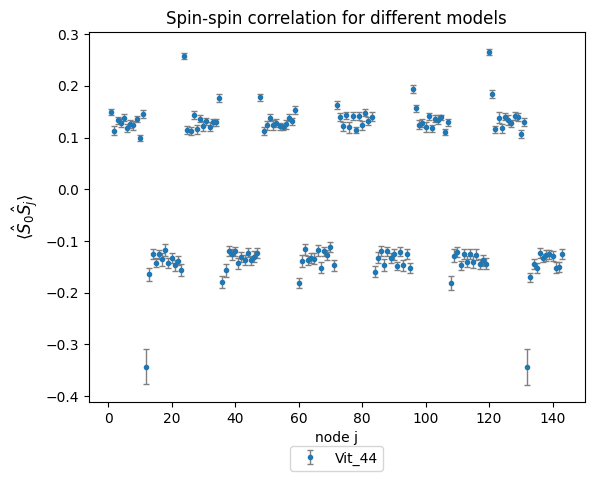

In [51]:
plt.figure()
plt.title('Spin-spin correlation for different models')
plt.ylabel(r'$\langle \hat{{S}}_0 \hat{S}_j \rangle$', fontsize=12)
plt.xlabel('node j')
for key in SpinSpin_Corrs_12.keys():
    # plt.plot(np.arange(1,144),np.real(SpinSpin_Corrs_12[key]), marker='.', linestyle='', label=key)
    plt.errorbar(x=np.arange(1,144), y=np.real(SpinSpin_Corrs_12[key]), yerr=SpinSpin_Corrs_12_err[key], fmt='.', ecolor='gray', elinewidth=1, capsize=2, label=key)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=3)
plt.show()

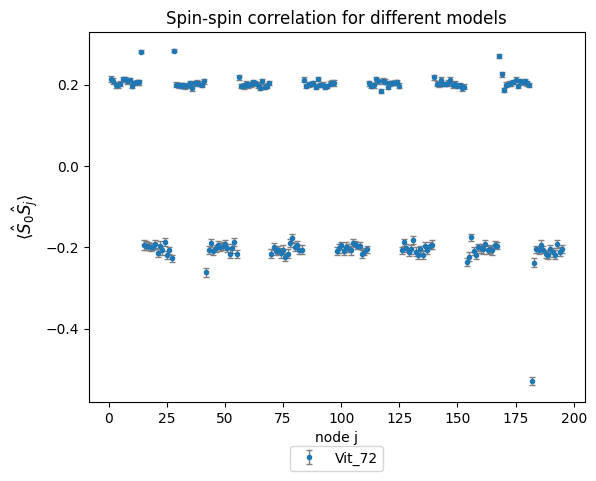

In [52]:
plt.figure()
plt.title('Spin-spin correlation for different models')
plt.ylabel(r'$\langle \hat{{S}}_0 \hat{S}_j \rangle$', fontsize=12)
plt.xlabel('node j')

for key in SpinSpin_Corrs_14.keys():
    plt.errorbar(x=np.arange(1,196), y=np.real(SpinSpin_Corrs_14[key]), yerr=SpinSpin_Corrs_14_err[key], fmt='.', ecolor='gray', elinewidth=1, capsize=2, label=key)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=3)
plt.show()

## Structure Factor for L=12

In [18]:
pi = np.pi
nodes = [
    (-4*pi/3, 0),  # Leftmost node
    (-2*pi/3, -2*pi/np.sqrt(3)),  # Bottom left
    (2*pi/3, -2*pi/np.sqrt(3)),  # Bottom right
    (4*pi/3, 0),  # Rightmost node
    (2*pi/3, 2*pi/np.sqrt(3)),  # Top right
    (-2*pi/3, 2*pi/np.sqrt(3)),  # Top left
    (-4*pi/3, 0)  # Close the hexagon by repeating the first node
]

x_coords, y_coords = zip(*nodes)

In [16]:
ks12 = FourierPoints_In_BrioullinZone(12, 100)

In [43]:
ds = Create_Differences(Tri12)
sss12, ss_err12 = Create_SpinSpin_Vec(vs_vit_44, hi12, Tri12, make_rotation=True, sublattice=pHa['sublattice_12'], get_error=True, sharding=True)
# FourierPoints_In_BrioullinZone
Sk_12, Sk_errs12 = vmap(Single_Struc_Fac, in_axes=(0, None, None, None, None))(((ks12)), ds, sss12, hi12.size, ss_err12)


In [41]:
with open('/scratch/samiz/GPU_ViT_Calcs/Vscore_ThermodynamicLimit_Analysis/0Lx0L_ViT_Refined_Learning/Structure_Factor_L12_vit.pickle', 'wb') as f:
    pickle.dump(Sk_12, f)
with open('/scratch/samiz/GPU_ViT_Calcs/Vscore_ThermodynamicLimit_Analysis/0Lx0L_ViT_Refined_Learning/Structure_Factor_L12_vit_errs.pickle', 'wb') as f:
    pickle.dump(Sk_errs12, f)

In [3]:
with open('/scratch/samiz/GPU_ViT_Calcs/Vscore_ThermodynamicLimit_Analysis/0Lx0L_ViT_Refined_Learning/Structure_Factor_L12_vit.pickle', 'rb') as handle:
    Sk_12 = pickle.load(handle)
with open('/scratch/samiz/GPU_ViT_Calcs/Vscore_ThermodynamicLimit_Analysis/0Lx0L_ViT_Refined_Learning/Structure_Factor_L12_vit_errs.pickle', 'rb') as handle:
    Sk_errs12 = pickle.load(handle)

In [4]:
print(np.max(Sk_12))
inds = np.where(Sk_12 == np.max(Sk_12))
print(Sk_errs12[inds])


(69.5154042558118+0.03552036086232294j)
[0.03014032 0.03014032]


In [17]:
print(np.where(np.all(np.isclose(ks12 , (3.14159, 0.0)), axis=1)))

print(Sk_12[414])

(array([414]),)
(5.842751708816637-0.00298814720856578j)


/scratch/samiz/venv/lib/python3.11/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/scratch/samiz/venv/lib/python3.11/site-packages/matplotlib/cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


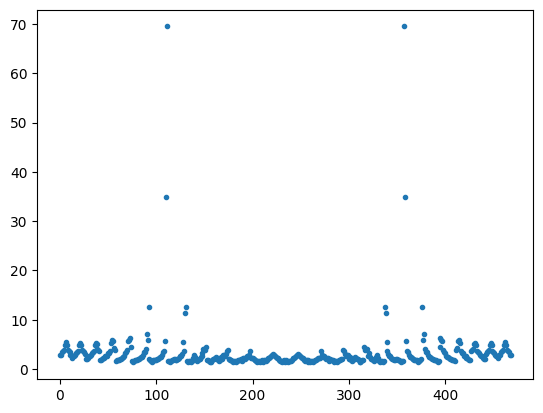

In [31]:
plt.plot(Sk_12, '.')

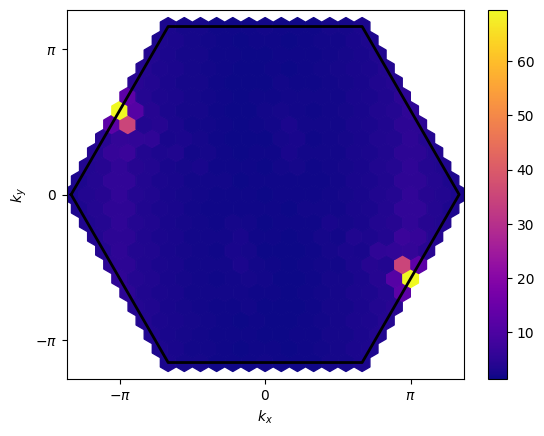

In [45]:
thickness =  24000 / L**2 
plt.plot(x_coords, y_coords, linestyle='-', color='black', linewidth=2, marker='')
plt.scatter(ks12[:,0], ks12[:,1], c=Sk_12.real, cmap='plasma', s=thickness, marker='h')
# plt.scatter(kx,ky, c=Sk_rbm1.real, cmap='plasma', s=20, marker='o')
ticks = [-np.pi, 0, np.pi]
tick_labels = [r'$-\pi$', r'$0$', r'$\pi$']
plt.xticks(ticks, tick_labels)
plt.yticks(ticks, tick_labels)
plt.xlabel(r'$k_x$')
plt.ylabel(r'$k_y$')
plt.colorbar()
plt.axis('equal')
# plt.ylim(-np.pi, np.pi)
plt.xlim(-np.pi, np.pi)

plt.show()


In [20]:
ds = Create_Differences(Tri12)
ss_rbm12, ss_err_rbm12 = Create_SpinSpin_Vec(vs_rbm1, hi12, Tri12, make_rotation=True, sublattice=pHa['sublattice_12'], get_error=True, sharding=True)
# FourierPoints_In_BrioullinZone
Sk_rbm12, Sk_errs_rbm12 = vmap(Single_Struc_Fac, in_axes=(0, None, None, None, None))(((ks12)), ds, ss_err_rbm12, hi12.size, ss_err_rbm12)


In [21]:
with open('/scratch/samiz/GPU_ViT_Calcs/Vscore_ThermodynamicLimit_Analysis/0Lx0L_ViT_Refined_Learning/StructureFactor_rbm1_L12.pickle', 'wb') as f:
    pickle.dump(Sk_rbm12, f)

with open('/scratch/samiz/GPU_ViT_Calcs/Vscore_ThermodynamicLimit_Analysis/0Lx0L_ViT_Refined_Learning/StructureFactorErrs_rbm1_L12.pickle', 'wb') as handle:
    pickle.dump(Sk_errs_rbm12, handle)

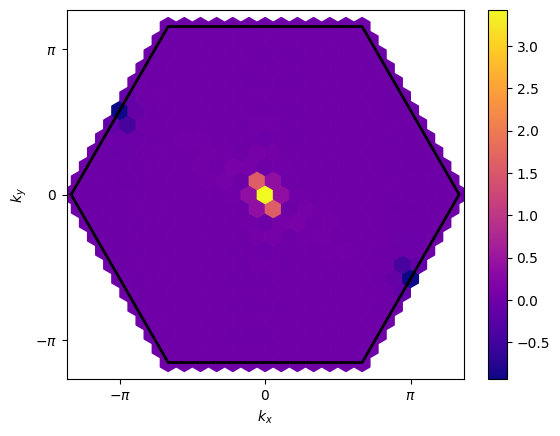

In [22]:
thickness =  24000 / L**2 
plt.plot(x_coords, y_coords, linestyle='-', color='black', linewidth=2, marker='')
plt.scatter(ks12[:,0], ks12[:,1], c=Sk_rbm12.real, cmap='plasma', s=thickness, marker='h')
# plt.scatter(kx,ky, c=Sk_rbm1.real, cmap='plasma', s=20, marker='o')
ticks = [-np.pi, 0, np.pi]
tick_labels = [r'$-\pi$', r'$0$', r'$\pi$']
plt.xticks(ticks, tick_labels)
plt.yticks(ticks, tick_labels)
plt.xlabel(r'$k_x$')
plt.ylabel(r'$k_y$')
plt.colorbar()
plt.axis('equal')
# plt.ylim(-np.pi, np.pi)
plt.xlim(-np.pi, np.pi)

plt.show()


## Structure Factor for L=14

In [23]:
ks14 = FourierPoints_In_BrioullinZone(14, 100)

In [25]:
ds = Create_Differences(Tri14)
sss_14, ss_errs_14 = Create_SpinSpin_Vec(vs_vit_72, hi14, Tri14, make_rotation=True, sublattice=pHa['sublattice_14'], get_error=True, sharding=True)
# FourierPoints_In_BrioullinZone
Sk_14, Sk_14_errs = vmap(Single_Struc_Fac, in_axes=(0, None, None, None, None))(((ks14)), ds, sss_14, hi14.size, ss_errs_14)

In [26]:
with open('/scratch/samiz/GPU_ViT_Calcs/Vscore_ThermodynamicLimit_Analysis/0Lx0L_ViT_Refined_Learning/Structure_Factor_L14_vit.pickle', 'wb') as f:
    pickle.dump(Sk_14, f)
with open('/scratch/samiz/GPU_ViT_Calcs/Vscore_ThermodynamicLimit_Analysis/0Lx0L_ViT_Refined_Learning/Structure_Factor_L14_vit_errs.pickle', 'wb') as f:
    pickle.dump(Sk_14_errs, f)

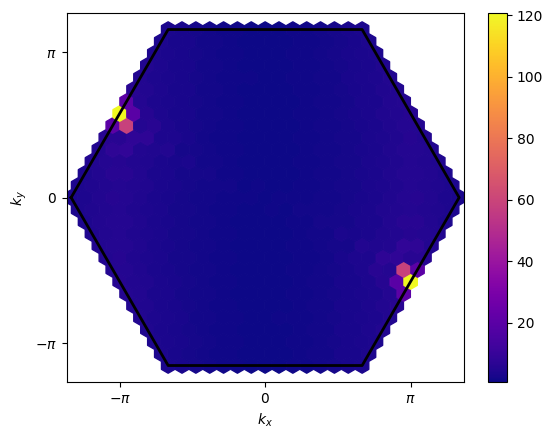

In [27]:
thickness =  24000 / 14**2 
plt.plot(x_coords, y_coords, linestyle='-', color='black', linewidth=2, marker='')
plt.scatter(ks14[:,0], ks14[:,1], c=Sk_14.real, cmap='plasma', s=thickness, marker='h')
# plt.scatter(kx,ky, c=Sk_rbm1.real, cmap='plasma', s=20, marker='o')
ticks = [-np.pi, 0, np.pi]
tick_labels = [r'$-\pi$', r'$0$', r'$\pi$']
plt.xticks(ticks, tick_labels)
plt.yticks(ticks, tick_labels)
plt.xlabel(r'$k_x$')
plt.ylabel(r'$k_y$')
plt.colorbar()
plt.axis('equal')
# plt.ylim(-np.pi, np.pi)
plt.xlim(-np.pi, np.pi)

plt.show()